
#  The No-show appointments dataset Investigation
### by Muhammad faleh almutiri 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#correlation Analysis">correlation Analysis</a></li>
<li><a href="#Data pre-processing">Data pre-processing</a></li>
<li><a href="#Model Training & Testing">Model Training & Testing</a></li>
<li><a href="#Conclusion">Conclusion</a></li>
</ul>

<a id='intro'></a>
## Introduction
> i will look in this investigation at No-show appointments dataset, i will look at Exploratory Data Analysis, correlation Analysis, data balancing and applying machine learning models on the data, the models to be tested are:
1. bagging + random forrest
2. bagging + MLP
3. bagging + KNN
### Dataset Description  

>The dataset analyzed was the **No-show appointments dataset** which includes information about 100k medical appointments that were made in 2016 in brazil which asks the question of whether or not patients show up for their appointment,
‘ScheduledDay’ (which day the patient set up their appointment

   1. 'PatientId' (a unqiue number used to refer to the Patient)
   2. 'AppointmentID' (a unqiue number used to refer to the Appointment day)
   3. 'ScheduledDay' (which day the patient set up their appointment)
   4. 'AppointmentDay' (the date on which the appointment was made)
   5. 'Gender' (the gender of the patient)
   6. 'Age' (Patient Age)
   7. 'Neighbourhood' (the hospital Neighbourhood)
   8. 'Scholarship' (indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família)
   9. Hipertension,Diabetes,Alcoholism,Handcap (all indiacte the diseases)
   10. 'SMS_received' (wheather or not the patient received an sms about the appointment)
   11. 'No_show' (wheather or not the patient attended the appointment No means they did)



### Question(s) for the Exploratory & Correlation Analysis
<li><a href="#Q2">What gender is least to attend / more ?</a></li>
    <li><a href="#Q3">What’s the age disruption ? </a></li>
    <li><a href="#Q4">What disease is more to attend / less</a></li>
    <li><a href="#Q5">Which week day have the most attendedes/appointments made</a></li>
    <li><a href="#Q7">What is the date of the  min max attendants/appointments in a day</a></li>
    <li><a href="#Q1">Is there a relation between receiving an sms and attending ? </a></li>
    <li><a href="#Q8">Is there a relation between having a scholarship and attending ?</a></li>
    <li><a href="#Q9">Is there a relation between Gender and attending </a></li>
    <li><a href="#10">Is there a relation between disease attending</a></li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import dateutil.parser
from scipy.stats import chi2_contingency
from imblearn.ensemble import BalancedBaggingClassifier
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import collections
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def model_val(labels_test,pred):
  cnf_matrix=confusion_matrix(labels_test,pred)
  print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
  fig= plt.figure(figsize=(6,3))# to plot the graph
  print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
  print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
  print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
  print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
  sb.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
  plt.title("Confusion_matrix")
  plt.xlabel("Predicted_class")
  plt.ylabel("Real class")
  plt.show()
  print("\n----------Classification Report------------------------------------")
  print(classification_report(labels_test,pred, digits=5))
  print(classification_report_imbalanced(labels_test, pred, digits=5))

> print the classification report 

In [3]:
def percentage(str1,str2, val1, val1_total, val2, val2_total):
    a = round((val1 / val1_total ) * 100, 3)
    b = round((val2 / val2_total ) * 100, 3)
    print(str1," : ", a,'%\n',str2," : ",b,'%')

Calculate percentages

In [4]:
def get_dis(df_, str):
    scholar_df = df_['No_show'].loc[(df_['Scholarship'] == 1) & (df_['No_show'] == str)]
    hiper_df = df_['No_show'].loc[(df_['Hipertension'] == 1 )& (df_['No_show'] == str)]
    dia_df = df_['No_show'].loc[(df_['Diabetes'] == 1)& (df_['No_show'] == str)]
    alco_df = df_['No_show'].loc[(df_['Alcoholism'] == 1)& (df_['No_show'] == str)]
    hand_df = df_['No_show'].loc[(df_['Handcap'] == 1)& (df_['No_show'] == str)]
    no_dis_df = df_['No_show'].loc[(df_['Hipertension'] == 0) & (df_['Handcap'] == 0) & (df_['Alcoholism'] == 0)
                           & (df_['Diabetes'] == 0) & (df_['No_show'] == str)]
    
    return np.array([len(no_dis_df),len(hiper_df), len(scholar_df), len(dia_df), len(alco_df),len(hand_df)])

Get a numpy array of the diseases/ scholarship

In [5]:
def sum_dates(df_, name, str1):
    df1 = df_.groupby(name).size().reset_index(name='count')
    df2 = df_.copy()
    a, b = df1[name].loc[df1['count'].idxmax()], \
           df1[name].loc[df1['count'].idxmin()]
    df2[name] = df_[name].dt.strftime('%a')
    df2 = df2.groupby(name).size().reset_index(name='count')
    if str1:
        print(f'{str1} maximum :\n{a}\n\n{str1} minimum :\n{b}\n')
    else:
        pass
    return df2

Calculate the min and max of sent dates and return a dataframe where dates are replaced by weekdays and added

In [6]:
def count_plot(df, xdata, dodge, width,title):


    plots = sb.countplot(data=df,x= xdata, dodge=dodge,width=width )
    for p in plots.patches:
        plots.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.04, p.get_height()+511))

    plt.title(title)


    plt.show()

<a id='wrangling'></a>
## Data Wrangling



In [7]:
df = pd.read_csv('noshowappointments.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No_show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


> the data has a total of 14 column, we can see that there's a total of 110527 rows.
> also we can see that AppointmentDay, ScheduledDay are set as an object , they should be a datetime or timestamp 

In [8]:
df.drop(columns=['AppointmentID'], axis=1, inplace=True)
df.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
0,2.987250e+13,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


>file reading, Dropping unwanted columns since appointment id is unique for each appointment


### Data Cleaning
> the first step is to check if the dataframe has any null datapoints, then checking for unrealstic values

In [9]:
df.isnull().values.any()


False

> check for negative ages

In [10]:
df.loc[df['Age'] < 0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show
99832,4.659432e+14,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


>None is epmty, but there's a negative value in Age we can droped it 

In [11]:
df.drop(df.loc[df['Age'] < 0 ].index, inplace=True)

>droping the negative row

<a id='eda'></a>
## Exploratory Data Analysis

> In this section we will explore the data by plotting and applying statistical tests

<a id="Q2"></a>
### What gender is least to attend / more ?

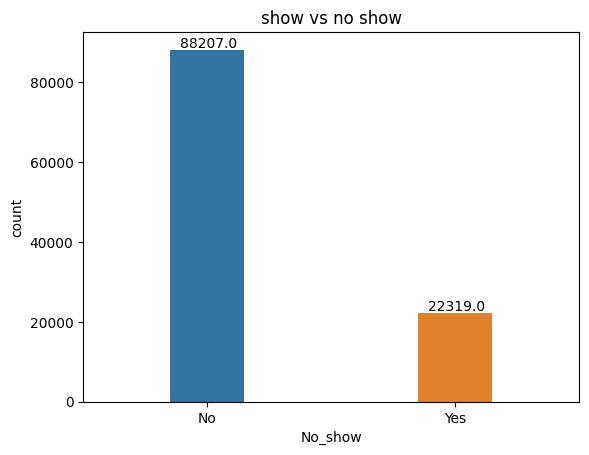

In [12]:
count_plot(df, 'No_show', False, 0.3, 'show vs no show')

> No here being people who showed to thier Appointment

 > <b> 1- we can see that the data is imblanced only 20% didn't show up  <b>

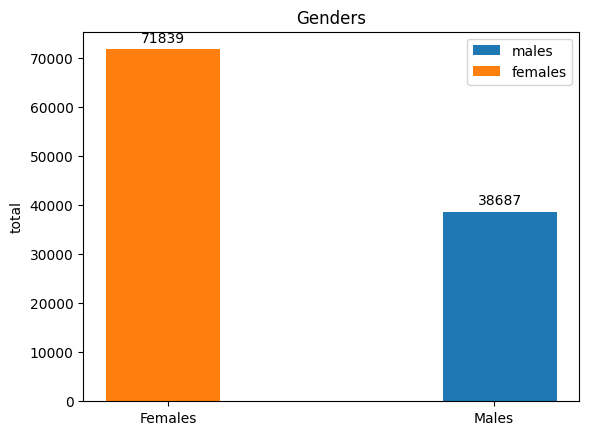

In [13]:
    figure, axis = plt.subplots()
    tik1 = ['Females', 'Males']
    x1 = np.arange(len(tik1))
    female_df = df.loc[df['Gender'] == 'F']
    male_df = df.loc[df['Gender'] == 'M']
    m = axis.bar(x1[1] + 0.1 / 6, len(male_df), 0.35, label='males')
    f = axis.bar(x1[0] - 0.1 / 6, len(female_df), 0.35, label='females')

    tki1 = ['Females', 'Males']
    x1 = np.arange(len(tik1))
    axis.set_xticks(x1, tik1)
    axis.set_ylabel('total')
    axis.title.set_text('Genders')
    axis.bar_label(m, padding=3) 
    axis.bar_label(f, padding=3) 
    plt.legend()
    plt.show()

>we can see that female patients are more than male patients, 

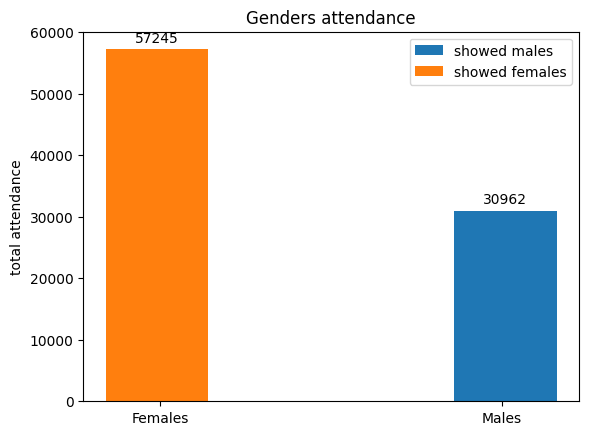

In [14]:
figure, axis = plt.subplots()

sm = axis.bar(x1[1] + 0.04 / 4, len(male_df.loc[male_df['No_show'] == 'No']), 0.3, label="showed males")
sf = axis.bar(x1[0] - 0.04 / 4, len(female_df.loc[female_df['No_show'] == 'No']), 0.3, label="showed females")

axis.set_xticks(x1, tik1)
axis.set_ylabel('total attendance')
axis.title.set_text('Genders attendance')


axis.bar_label(sf, padding=3)
axis.bar_label(sm, padding=3)

axis.legend()

>same goes with the number of attendance,
but on avg which attends more

In [15]:
percentage('Females','Males', len(female_df.loc[female_df['No_show'] == 'No'])
           , len(female_df), len(male_df.loc[male_df['No_show'] == 'No'])
           , len(male_df))

Females  :  79.685 %
 Males  :  80.032 %


>males have a higher avg but not by much

<a id="Q3"></a></li>
### What’s the age disruption

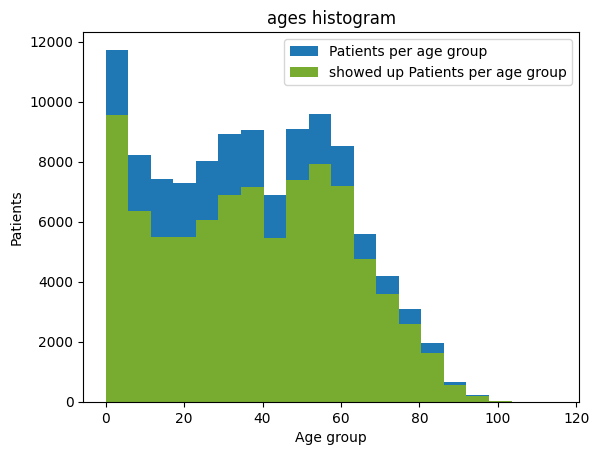

In [16]:
figure, axis = plt.subplots()
axis.hist(df['Age'], label='Patients per age group', bins=20)
axis.hist(df['Age'].loc[df['No_show'] == 'No'], label='showed up Patients per age group', color="#77AC30", bins=20)
axis.title.set_text('ages histogram')
plt.ylabel("Patients")
plt.xlabel("Age group")
axis.legend()


>we can see that the biggest age group is bellow 10 while the least are above 85 


<a id="Q4"></a></li>
### What disease is more to attend / less

In [17]:
show_male_array = get_dis(male_df, "No")
show_female_array = get_dis(female_df, "No")
total_male_dis = np.add(show_male_array, get_dis(male_df, "Yes"))
total_female_dis = np.add(show_female_array, get_dis(female_df, "Yes"))

Get dieases and shcolar for each gender 

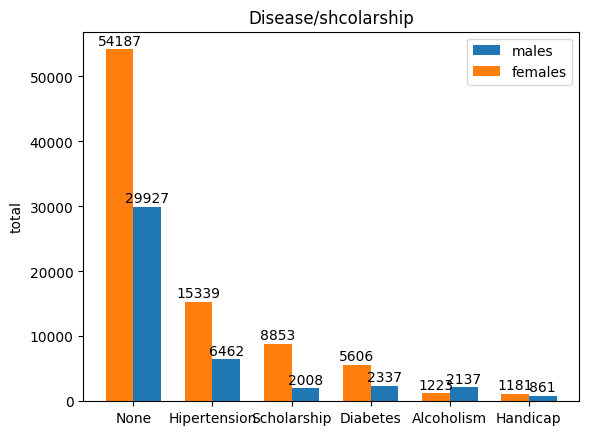

In [18]:
    figure, axis = plt.subplots()
    tik0 = ['None','Hipertension', 'Scholarship',  'Diabetes', 'Alcoholism', 'Handicap']
    x = np.arange(len(tik0))
    width = .35

    m = axis.bar(x + width / 2, total_male_dis, width, label='males')
    f = axis.bar(x - width / 2,  total_female_dis, width, label='females')
    axis.set_xticks(x, tik0)
    axis.set_ylabel('total')
    axis.title.set_text('Disease/shcolarship')
    axis.bar_label(m, padding=1)
    axis.bar_label(f, padding=1)
    axis.legend()

>We can see from the graph that most patients have other disease,
followed by patients who suffer from hypertension, (female lead on all
except alcoholism)

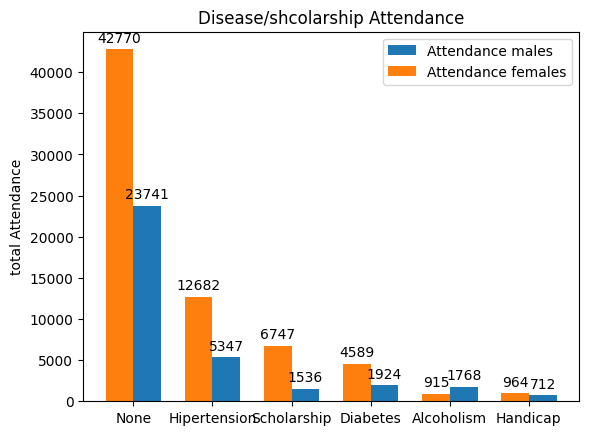

In [19]:
    figure, axis = plt.subplots()

    m = axis.bar(x + width / 2, show_male_array, width, label='Attendance males')
    f = axis.bar(x - width / 2,  show_female_array, width, label='Attendance females')
    axis.set_xticks(x, tik0)
    axis.set_ylabel('total Attendance')
    axis.title.set_text('Disease/shcolarship Attendance')
    axis.bar_label(m, padding=3)
    axis.bar_label(f, padding=3)
    axis.legend()

In [20]:
perc_male = np.multiply(np.divide(show_male_array, total_male_dis), 100)
perc_female = np.multiply(np.divide(show_female_array,total_female_dis),100)
print(perc_male,"\n",perc_female)

[79.32970228 82.7452801  76.4940239  82.32777065 82.73280299 82.69454123] 
 [78.93037075 82.67814069 76.21145374 81.8587228  74.81602617 81.6257409 ]


>highest attendance in male is for alcoholism (82.73%) followed by handicap (82.69%) and diabetes (82.32%)
highest attendance in female is for hipertension (82.67%) followed by handicap (81.85%) and None (other diseases 78.93%) 

(output have the same order as the graph)


<a id="Q5"></a></li>
### What is the date of the min max  attendants/appointment made in a day / 

>lets first make AppointmentDay , ScheduledDay into datetime so we can proccess them 

In [21]:
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'], format="%Y-%m-%d", errors='coerce') # changing data format
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'], format="%Y-%m-%d", errors='coerce')
show_df = df.loc[df['No_show'] == 'No']
df_sum_appointment_dates = sum_dates(df,'AppointmentDay', 'Appointment made per day')


df_sumed_Scheduled_dates = sum_dates(df,'ScheduledDay', False)

df_sumed_Attendance_dates = sum_dates(show_df,
                                          'ScheduledDay', 'Attendance per day')

Appointment made per day maximum :
2016-06-06 00:00:00+00:00

Appointment made per day minimum :
2016-05-14 00:00:00+00:00

Attendance per day maximum :
2016-03-29 10:44:23+00:00

Attendance per day minimum :
2015-11-10 07:13:56+00:00



<a id="Q6"></a></li>
### Which week day is most attended/appointment made in a day 

appointments made per weekday plotting

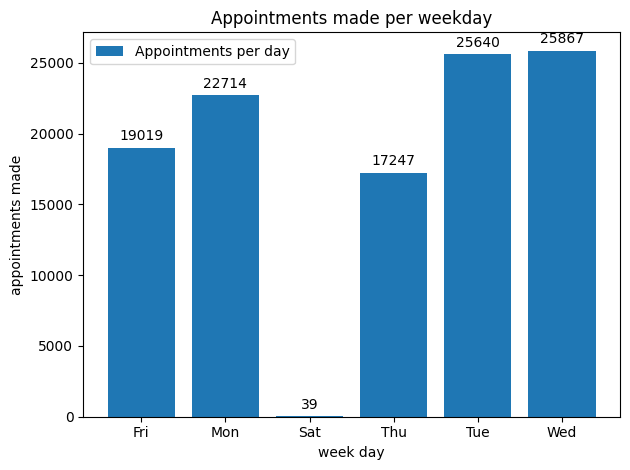

In [22]:
fig, axis = plt.subplots()

sf = axis.bar(df_sum_appointment_dates['AppointmentDay'], df_sum_appointment_dates['count'], label='Appointments per day')
axis.bar_label(sf, padding=3)
axis.title.set_text("Appointments made per weekday")
axis.set_ylabel("appointments made")
axis.set_xlabel("week day")
axis.legend()
plt.tight_layout()
plt.show()

>We can see from the graph that saturday does have the least  amount of appointments made, while wednesday have the highest

Number of schedules per weekday plotting

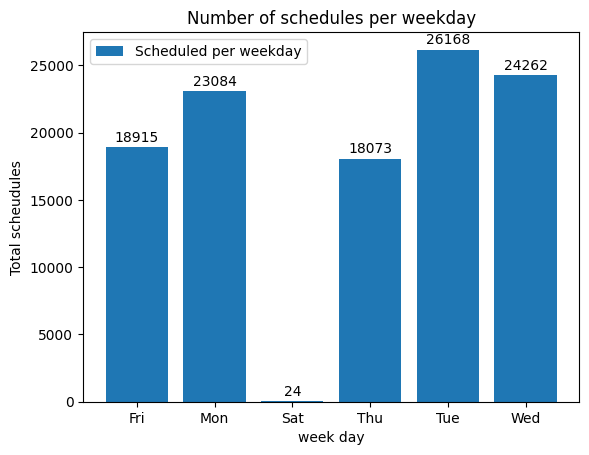

In [23]:
fig, axis = plt.subplots()
a = axis.bar(df_sumed_Scheduled_dates['ScheduledDay'], df_sumed_Scheduled_dates['count']
                   , label='Scheduled per weekday')
axis.set_ylabel("Total scheudules")
axis.set_xlabel("week day")
axis.bar_label(a, padding=2)
axis.title.set_text("Number of schedules per weekday")
axis.legend()

>we can see from this graph that the lowest picked Scheduled weekday is Sat, and the highest is Tue 

Number of Attendance per weekday plotting

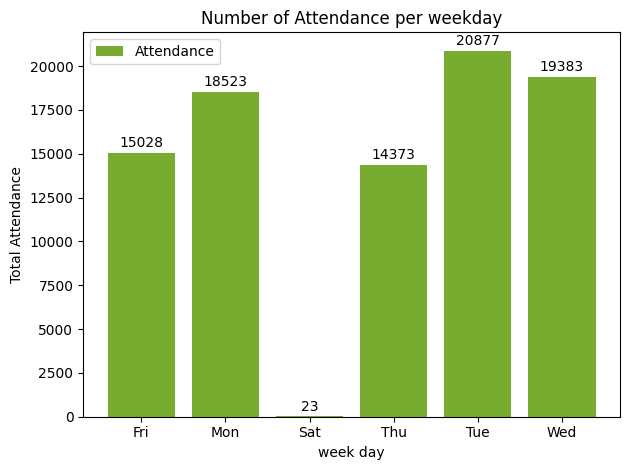

In [24]:
fig, axis = plt.subplots()
sf = axis.bar(df_sumed_Attendance_dates['ScheduledDay'], df_sumed_Attendance_dates['count'],
                   label='Attendance', color="#77AC30")
axis.title.set_text("Number of Attendance per weekday")
axis.set_ylabel("Total Attendance")
axis.set_xlabel("week day")
axis.bar_label(sf, padding=2)
axis.legend()
plt.tight_layout()
plt.show()

>we can see from this graph that the lowest picked Attendance weekday is Sat, and the highest is Tue 

<a id="correlation Analysis"></a></li>
## correlation Analysis

<a id="Q1"></a></li>
### Is there a relation between receiving an sms and attending ?  

call chi square and print the final result (if p is more than 5% recject if less accept) 

In [25]:
def hipo(arr, hippo):  # , x, y, val_of_x, val_of_y
    chi, p, dim, ar = chi2_contingency(arr)

    if p < 0.05:
        print(hippo, ' is accepted there is dependence p : ', round(p,5))
    else:
        print(hippo, ' is rejected there is independence p : ', round(p,5))

Send a 2d numpy array that contains ([sms, show, sms, NoShow],[NoSms, show, Nosms, NoShow])

In [26]:
sms_hipo_arr = np.array([[len(df.loc[(df['SMS_received'] == 0) & (df['No_show'] == 'No')]),
                    len(df.loc[(df['SMS_received'] == 0) & (df['No_show'] == 'Yes')])]
                       , [len(df.loc[(df['SMS_received'] == 1) & (df['No_show'] == 'No')]),
                    len(df.loc[(df['SMS_received'] == 1) & (df['No_show'] == 'Yes')])]])
hipo(sms_hipo_arr, "There is a relation between SMS and attendance")

There is a relation between SMS and attendance  is accepted there is dependence p :  0.0


<a id="Q8"></a></li>
### Is there a relation between having a scholarship and attending ?  

Send a 2d numpy array that contains ([Scholar, show, Scholar, NoShow],[NoScholar, show, NoScholar, NoShow])

In [27]:
Scholar_hipo_arr = np.array([[len(df.loc[(df['Scholarship'] == 0) & (df['No_show'] == 'No')]),
                    len(df.loc[(df['Scholarship'] == 0) & (df['No_show'] == 'Yes')])]
                       , [len(df.loc[(df['Scholarship'] == 1) & (df['No_show'] == 'No')]),
                    len(df.loc[(df['Scholarship'] == 1) & (df['No_show'] == 'Yes')])]])
hipo(Scholar_hipo_arr, "There is a relation between Scholarship and attendance")

There is a relation between Scholarship and attendance  is accepted there is dependence p :  0.0


<a id="Q9"></a></li>
### Is there a relation between Gender and attending ? 

Send a 2d numpy array that contains ([Female, show, Female, NoShow],[Male, show, Male, NoShow])

In [28]:
gen_hipo_arr = np.array([[len(df.loc[(df['Gender'] == 'F') & (df['No_show'] == 'No')]),
                    len(df.loc[(df['Gender'] == 'F') & (df['No_show'] == 'Yes')])]
                       , [len(df.loc[(df['Gender'] == 'M') & (df['No_show'] == 'No')]),
                    len(df.loc[(df['Gender'] == 'M') & (df['No_show'] == 'Yes')])]])
hipo(gen_hipo_arr, "There is a relation between Gender and attendance")

There is a relation between Gender and attendance  is rejected there is independence p :  0.17303


<a id="Q10"></a></li>
### Is there a relation between disease attending ? 

Getting the number of diseases for showing and not showing patients

In [29]:
show_dis_array = np.add(show_female_array, show_male_array)
total_dis_array = np.add(total_male_dis, total_female_dis)
NoShow_dis_array = np.subtract(total_dis_array, show_dis_array)


Send a 2d numpy array that contains ([NoDis, show, NoDis, NoShow],[hypertenison, show, hypertenison, NoShow],['Scholarship', show, 'Scholarship', NoShow], [Diabetes, show, Diabetes, NoShow],[Alcoholism, show, Alcoholism, NoShow] [Handicap, show, Handicap, NoShow])

In [30]:

dis_hipo_arr = np.array([[show_dis_array[0],NoShow_dis_array[0]],[show_dis_array[1],NoShow_dis_array[1]],
                        [show_dis_array[2],NoShow_dis_array[2]],[show_dis_array[3],NoShow_dis_array[3]],
                        [show_dis_array[4],NoShow_dis_array[4]],[show_dis_array[5],NoShow_dis_array[5]]])
hipo(dis_hipo_arr, "There is a relation between disease and attendance")

There is a relation between disease and attendance  is accepted there is dependence p :  0.0


<a id='Data pre-processing'></a>
# Data pre-processing

> in this section i will look at balancing the data and splting them 

> first of all lets create all the dummpy values we need, and map no show and gender into 0 and 1 

In [31]:

df_clean = df.copy()
df_clean['No_show'] =df_clean['No_show'].map(({'No': 0,  'Yes': 1}))
df_clean['Gender'] = df_clean['Gender'].map(({'F': 0,  'M': 1}))

df_clean['ap_year'] = df_clean['AppointmentDay'].dt.year
df_clean['ap_month'] = df_clean['AppointmentDay'].dt.month
df_clean['ap_day'] = df_clean['AppointmentDay'].dt.day

df_clean['sc_year'] = df_clean['ScheduledDay'].dt.year
df_clean['sc_month'] = df_clean['ScheduledDay'].dt.month
df_clean['sc_day'] = df_clean['ScheduledDay'].dt.day

df_clean.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No_show,ap_year,ap_month,ap_day,sc_year,sc_month,sc_day
0,2.987250e+13,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016,4,29,2016,4,29
1,5.589978e+14,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016,4,29,2016,4,29
2,4.262962e+12,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016,4,29,2016,4,29
3,8.679512e+11,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016,4,29,2016,4,29
4,8.841186e+12,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016,4,29,2016,4,29


> maping the gender and y value into 1 and 0 
(0 : female, 1: male), (0: show, 1: no show)

> spliting the dates into dummy values 

In [32]:
# arr = ['MATA DA PRAIA', 'ANDORINHAS', 'DA PENHA',
#        'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
#        'GRANDE VITÓRIA', 'JABOUR', 'ILHA DE SANTA MARIA', 'JUCUTUQUARA',
#        'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'SANTA HELENA', 'INHANGUETÁ',
#        'UNIVERSITÁRIO', 'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO',
#        'PARQUE MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'PRAIA DO CANTO',
#        'ESTRELINHA', 'FORTE SÃO JOÃO', 'ENSEADA DO SUÁ', 'SANTOS REIS',
#        'ROMÃO', 'COMDUSA', 'SANTA CECÍLIA', 'VILA RUBIM', 'DE LOURDES',
#        'SEGURANÇA DO LAR', 'ILHA DO BOI', 'FRADINHOS', 'NAZARETH',
#        'AEROPORTO']

# arr = ['MORADA DE CAMBURI','PONTAL DE CAMBURI','ILHA DO BOI','ILHA DO FRADE',
#        'AEROPORTO','ILHAS OCEÂNICAS DE TRINDADE','PARQUE INDUSTRIAL']

# df_clean = df_clean.loc[~df_clean['Neighbourhood'].isin(arr)]


In [33]:
a = df_clean.Neighbourhood.drop_duplicates()

print(a.tolist())

['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI', 'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA', 'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE', 'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS', 'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI', 'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA', 'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO', 'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ', 'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO', 'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO', 'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA', 'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA', 'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO JOÃO', 'FONTE GRANDE', 'ENSEADA DO SUÁ', 'SANTOS REIS', 'PIEDADE', 'JESUS DE NAZARETH', 'SANTA TEREZA', 

In [34]:
df_clean[a] = pd.get_dummies(df_clean['Neighbourhood'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 100 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   PatientId                    110526 non-null  float64            
 1   Gender                       110526 non-null  int64              
 2   ScheduledDay                 110526 non-null  datetime64[ns, UTC]
 3   AppointmentDay               110526 non-null  datetime64[ns, UTC]
 4   Age                          110526 non-null  int64              
 5   Neighbourhood                110526 non-null  object             
 6   Scholarship                  110526 non-null  int64              
 7   Hipertension                 110526 non-null  int64              
 8   Diabetes                     110526 non-null  int64              
 9   Alcoholism                   110526 non-null  int64              
 10  Handcap                      11

>after getting a list of all nighbourhoods i made them into dummpy columns
, current total is 101

In [35]:
# ,'ILHA DO BOI','ILHA DO FRADE','AEROPORTO','ILHAS OCEÂNICAS DE TRINDADE','PARQUE INDUSTRIAL'
y_clean = df_clean['No_show']
X_clean = df_clean.drop(['PatientId','No_show', 'Neighbourhood', 'ScheduledDay', 'AppointmentDay'], axis=1)
X_clean.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,ap_year,ap_month,...,DO QUADRO,DO CABRAL,HORTO,SEGURANÇA DO LAR,ILHA DO BOI,FRADINHOS,NAZARETH,AEROPORTO,ILHAS OCEÂNICAS DE TRINDADE,PARQUE INDUSTRIAL
0,0,62,0,1,0,0,0,0,2016,4,...,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,2016,4,...,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,2016,4,...,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,2016,4,...,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,2016,4,...,0,0,0,0,0,0,0,0,0,0


>spliting the data into features and output (x,y), y_clean here has the no show feature (output) , while x_clean has the rest of the features.

> x_clean : droping 'PatientId', and 'Neighbourhood', 'ScheduledDay', 'AppointmentDay' since we already made dummpy cloumns from them.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_clean,
                                                    y_clean,
                                                    test_size=0.2,
                                                    stratify=y_clean,
                                                    random_state=42)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22106 entries, 83379 to 48605
Data columns (total 95 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Gender                       22106 non-null  int64
 1   Age                          22106 non-null  int64
 2   Scholarship                  22106 non-null  int64
 3   Hipertension                 22106 non-null  int64
 4   Diabetes                     22106 non-null  int64
 5   Alcoholism                   22106 non-null  int64
 6   Handcap                      22106 non-null  int64
 7   SMS_received                 22106 non-null  int64
 8   ap_year                      22106 non-null  int64
 9   ap_month                     22106 non-null  int64
 10  ap_day                       22106 non-null  int64
 11  sc_year                      22106 non-null  int64
 12  sc_month                     22106 non-null  int64
 13  sc_day                       22106 non-nul

>test and train split before smote as to not pollute the model and make it unbiased, i went with 80% , 20% split 

In [37]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=50, step=1)
rfe = rfe.fit(X_train, y_train)

In [38]:
print('Chosen best 50 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 50 feature by rfe: Index(['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'ap_month', 'ap_day',
       'sc_month', 'sc_day', 'MATA DA PRAIA', 'ANDORINHAS', 'DA PENHA',
       'TABUAZEIRO', 'BENTO FERREIRA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'JABOUR', 'ILHA DE SANTA MARIA', 'JUCUTUQUARA',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'SANTA HELENA', 'INHANGUETÁ',
       'UNIVERSITÁRIO', 'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO',
       'PARQUE MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'PRAIA DO CANTO',
       'ESTRELINHA', 'FORTE SÃO JOÃO', 'ENSEADA DO SUÁ', 'SANTOS REIS',
       'ROMÃO', 'COMDUSA', 'SANTA CECÍLIA', 'VILA RUBIM', 'DE LOURDES',
       'SEGURANÇA DO LAR', 'ILHA DO BOI', 'FRADINHOS', 'NAZARETH',
       'AEROPORTO'],
      dtype='object')


> i tested the best 10 , 20 ,.... 50 and all of them got worse results than using all the features , the method used here is the random forest selector 

> lets check for the number of show and no show in both test and train splits

In [39]:
target_count = y_train.value_counts()
print('show:', target_count[0])
print('no show', target_count[1])
print("______")
target_count = y_test.value_counts()
print('show:', target_count[0])
print('no show', target_count[1])

show: 70565
no show 17855
______
show: 17642
no show 4464


> as seen here the no show only makes 20.1% in the train and test splits, let's look at smoting next to fix this.

In [40]:
from imblearn import under_sampling
rus = under_sampling.RandomUnderSampler(
    sampling_strategy={
        
        0: 70418

    },
    random_state=42
)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % collections.Counter(y_res))

Resampled dataset shape Counter({0: 70418, 1: 17855})


In [41]:
smt =SMOTE(sampling_strategy={1: 70418 },k_neighbors=10)
X_train_sm, y_train_sm = smt.fit_resample(X_res, y_res)

In [42]:
from imblearn import under_sampling
rus = under_sampling.RandomUnderSampler(
    sampling_strategy={
        
        0: 17604
    },
    random_state=42
)
X_rest, y_rest = rus.fit_resample(X_test, y_test)
print('Resampled dataset shape %s' % collections.Counter(y_rest))

Resampled dataset shape Counter({0: 17604, 1: 4464})


In [43]:
smt = SMOTE(sampling_strategy={1: 17604 },k_neighbors=10)
X_test_sm, y_test_sm = smt.fit_resample(X_rest, y_rest)

> smoting the no show to make it balnaced 

In [44]:
target_count = y_train_sm.value_counts()
print('show :', target_count[0])
print('no show :', target_count[1])

print("______")
target_count = y_test_sm.value_counts()
print('show :', target_count[0])
print('no show :', target_count[1])


Count_Normal_transacation = len(y_train_sm[y_train_sm==0]) # normal transaction are repersented by 0
Count_Fraud_transacation = len(y_train_sm[y_train_sm==1]) # fraud by 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("(train)percentage of normal transacation is",Percentage_of_Normal_transacation*100)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("(train)percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

Count_Normal_transacation = len(y_test_sm[y_test_sm==0]) # normal transaction are repersented by 0
Count_Fraud_transacation = len(y_test_sm[y_test_sm==1]) # fraud by 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("(test)percentage of normal transacation is",Percentage_of_Normal_transacation*100)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("(test)percentage of fraud transacation",Percentage_of_Fraud_transacation*100)

show : 70418
no show : 70418
______
show : 17604
no show : 17604
(train)percentage of normal transacation is 50.0
(train)percentage of fraud transacation 50.0
(test)percentage of normal transacation is 50.0
(test)percentage of fraud transacation 50.0


> now they're 50 50 split, we can scale the data and start training the models

In [45]:
X_test_sm_c = X_test_sm.copy()
X_train_sm_c = X_train_sm.copy()


scale = StandardScaler()
scale.fit(X_train_sm_c)

scale_t = StandardScaler()
scale_t.fit(X_test_sm_c)

sc_train =scale.transform(X_train_sm_c)
sc_test =scale_t.transform(X_test_sm_c)

> scaling the data for the knn and the MLP since both benfit greatly from scaling 

<a id='Model Training & Testing'></a>
# Model Training & Testing

>let's start with randomforest 

## Random Forest

In [58]:
model = BalancedBaggingClassifier(RandomForestClassifier( random_state=0), n_jobs=-1)


In [59]:
model.fit(X_train_sm, y_train_sm)

BalancedBaggingClassifier(estimator=RandomForestClassifier(random_state=0),
                          n_jobs=-1)

the recall for this model is : 0.7934560327198364
TP 13968
TN 15482
FP 2122
FN 3636


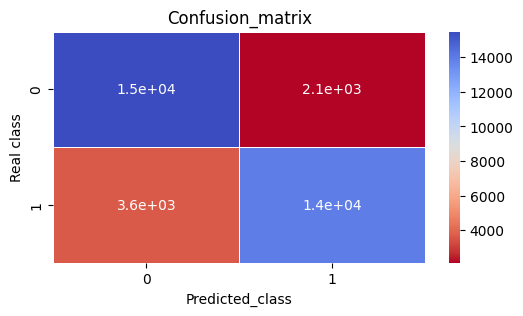


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.80981   0.87946   0.84320     17604
           1    0.86812   0.79346   0.82911     17604

    accuracy                        0.83646     35208
   macro avg    0.83896   0.83646   0.83615     35208
weighted avg    0.83896   0.83646   0.83615     35208

                   pre       rec       spe        f1       geo       iba       sup

          0    0.80981   0.87946   0.79346   0.84320   0.83535   0.70381     17604
          1    0.86812   0.79346   0.87946   0.82911   0.83535   0.69181     17604

avg / total    0.83896   0.83646   0.83646   0.83615   0.83535   0.69781     35208



In [60]:
y_pred_bag = model.predict(X_test_sm)
model_val(y_test_sm, y_pred_bag)

> the model got 83.8% in precision and 83.6 in recall which is the weakest of all the algorithms tested, next will check MLP

## MLP

> i went with adam as the slover and relu as the activation fuction with 120 hidden layers, and ensampling to help with the data imbalance 

In [49]:
model_svc = BalancedBaggingClassifier(MLPClassifier(solver='adam', activation= 'relu', hidden_layer_sizes=120, learning_rate_init=0.0015 ), n_jobs=-1)
model_svc.fit(sc_train, y_train_sm)

BalancedBaggingClassifier(estimator=MLPClassifier(hidden_layer_sizes=120,
                                                  learning_rate_init=0.0015),
                          n_jobs=-1)

the recall for this model is : 0.757725516927971
TP 13339
TN 16826
FP 778
FN 4265


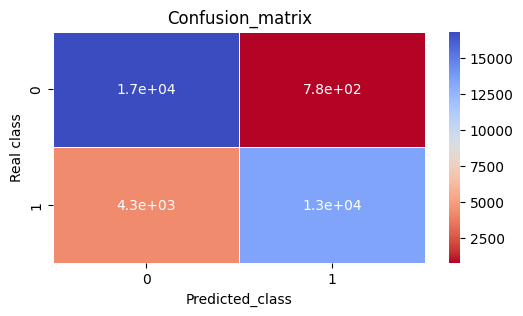


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.79778   0.95581   0.86967     17604
           1    0.94489   0.75773   0.84102     17604

    accuracy                        0.85677     35208
   macro avg    0.87134   0.85677   0.85535     35208
weighted avg    0.87134   0.85677   0.85535     35208

                   pre       rec       spe        f1       geo       iba       sup

          0    0.79778   0.95581   0.75773   0.86967   0.85102   0.73858     17604
          1    0.94489   0.75773   0.95581   0.84102   0.85102   0.70989     17604

avg / total    0.87134   0.85677   0.85677   0.85535   0.85102   0.72424     35208



In [50]:
y_pred = model_svc.predict(sc_test)
model_val(y_test_sm, y_pred)

> the model got 87.1% in precision and 85.6 in recall

> next lets check knn

## KNN

> before we can start we have to find the k number so let's test k from 1 till 40 to see which gives us the least error rate 

In [51]:
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(sc_train, y_train_sm)
    pred_i = knn.predict(sc_test)
    error_rate.append(np.mean(pred_i !=y_test_sm))

> let's plot the error rate 

Text(0, 0.5, 'Error Rate')

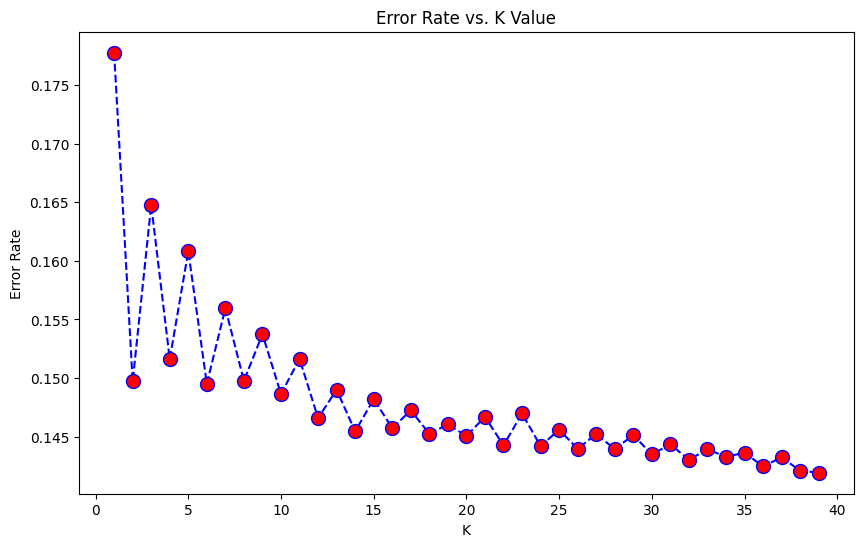

In [52]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

> we can see from the graph that around 38 we get the least error rate let's check the list to make sure 

In [53]:
np.argmin(error_rate)

38

In [56]:
modelknn = BalancedBaggingClassifier(KNeighborsClassifier(n_neighbors=38, weights='distance', algorithm='ball_tree', leaf_size=40)
, n_jobs=-1)
modelknn.fit(sc_train, y_train_sm) 

BalancedBaggingClassifier(estimator=KNeighborsClassifier(algorithm='ball_tree',
                                                         leaf_size=40,
                                                         n_neighbors=38,
                                                         weights='distance'),
                          n_jobs=-1)

the recall for this model is : 0.7545444217223358
TP 13283
TN 16903
FP 701
FN 4321


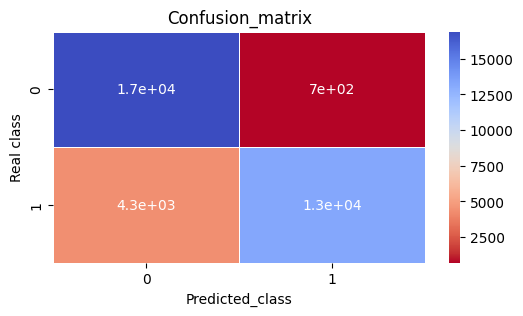


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0    0.79641   0.96018   0.87066     17604
           1    0.94987   0.75454   0.84102     17604

    accuracy                        0.85736     35208
   macro avg    0.87314   0.85736   0.85584     35208
weighted avg    0.87314   0.85736   0.85584     35208

                   pre       rec       spe        f1       geo       iba       sup

          0    0.79641   0.96018   0.75454   0.87066   0.85117   0.73940     17604
          1    0.94987   0.75454   0.96018   0.84102   0.85117   0.70960     17604

avg / total    0.87314   0.85736   0.85736   0.85584   0.85117   0.72450     35208



In [57]:
y_pred_knn = modelknn.predict(sc_test)
model_val(y_test_sm, y_pred_knn)

>the model got 87.3% precision  and 85.7% in recall, over all the best performer of all the algorithms tested 


<a id='Conclusion'></a>
## Conclusion

I Looked at the dataset and mananged to remove wrong/unwanted data, also made investgations for most of the independent varibles, compared them to each other and to dependent varibles(No show) through chi square and expolratory analysis, my findings:

   ### expolratory analysis
       1. Females Are 71839 (79.685 % attendance rate) while Males are 38687 (80.032 % attendance rate).
       2. The highest Age group are people below 10.
       3. Most patients have other disease or came for other reasons, followed by patients who suffer from hypertension
           are the second (female lead on all except alcoholism).
       4. Highest attendance in male is for alcoholism (82.73%) while females are for hypertension (82.67%). 
       5. Most appointments were made on Wedensday.
       6. Most Desired week day for schedules is Tuesday.
       7. Most Attended week day is Tuesday.
       8. Least desired week day is Saturday.
   
   ### correlation Analysis
       1. There is a strong relation between receiving an SMS attending.
       2. There is a strong relation between Scholarship and attendance.
       3. There is independence between Gender attending.
       4. There is a strong relation between disease attending.
   
   ### model testing
       1. the random forrest model got 83.8% in precision and 83.6% in recall. (the worst performer)
       2. the MLP model got 87.1% in precision and 85.6% in recall. (the second best performer)
       3. the KNN model got 87.3% precision and 85.7% in recall. (the best performer)
   
